<h1>imports</h1>

In [1]:
import numpy as np
import pandas as pd
# import modin.pandas as pd
import dask
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt
from urllib import request
import json
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, Normalizer, Binarizer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# from imblearn.over_sampling import SMOTE
from collections import Counter

import time
# print each command: 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from IPython.core.debugger import set_trace

from multiprocessing import  Pool

In [2]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:56417 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


<h1>load data</h1>

In [3]:
data_path = './data/'

In [4]:
%%time
train_accounts = pd.read_csv(data_path + 'train_accounts.csv')#.sample(frac=0.2)
train_users = pd.read_csv(data_path + 'train_users.csv')
train_events = pd.read_csv(data_path + 'train_events.csv')
train_subscriptions = pd.read_csv(data_path + 'train_subscriptions.csv')
test_accounts = pd.read_csv(data_path + 'test_accounts.csv')
test_users = pd.read_csv(data_path + 'test_users.csv')
test_events = pd.read_csv(data_path + 'test_events.csv')
test_subscriptions = pd.read_csv(data_path + 'test_subscriptions.csv')

<string>:2: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 45.2 s


In [5]:
%%time
accounts = pd.concat([train_accounts, test_accounts],sort=False)
print(f'accounts: {len(accounts)}')
users = pd.concat([train_users, test_users],sort=False)
print(f'users: {len(users)}')
events = pd.concat([train_events, test_events],sort=False)
print(f'events: {len(events)}')
subscriptions = pd.concat([train_subscriptions, test_subscriptions],sort=False)
print(f'subscriptions: {len(subscriptions)}')

accounts: 1433661
users: 2251403
events: 17981537
subscriptions: 138135
Wall time: 5.92 s


In [6]:
# convert to dask df: 
# accountsd=dd.from_pandas(accounts,npartitions=1)
# usersd=dd.from_pandas(users,npartitions=1)
# eventsd=dd.from_pandas(events,npartitions=1)
# subscriptions=dd.from_pandas(subscriptions,npartitions=1)
# dask.compute()

<h1>feature engineering</h1>

## direct numerical correlation
First lets exampain the correlation between all numerical columns in "accounts" and the target columns "lead_score":

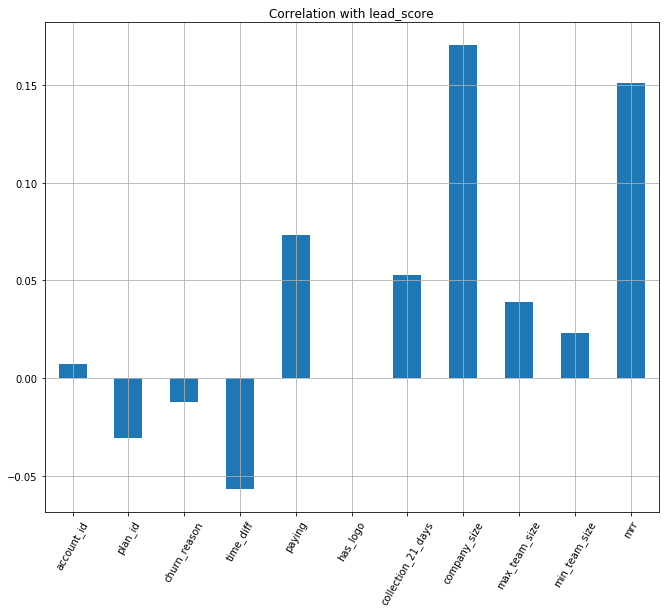

In [7]:
corrmat = accounts.select_dtypes('number').corr()
f, ax = plt.subplots(figsize = (11,9))
corrmat['lead_score'][0:-1].plot(kind='bar',rot=60)
plt.title('Correlation with lead_score')
plt.grid();

seems like the best features would be "company_size" and "mmr", and maybe also "paying", "collection_21_days" and "time_diff". 

Next, we examine numerical features from the other 3 tables. The approach here is to calculate the sum (and other several statistics) of each columns for each account, and then find which of them has correlation with the target: 

In [340]:
def groupby_above(df,df_name,d):
    n_df = df.groupby('account_id')[df.columns[1]].count()
    idx1 = n_df.iloc[n_df.values<=d]
    idx2 = n_df.iloc[n_df.values>d]
    print('{} accounts with more than {} {}.'.format(len(idx2),d,df_name))
    return idx1, idx2
idx1_us, idx2_us = groupby_above(events,'events',500)


12 accounts with more than 500 events.


In [341]:
%%time
# # tnames = ['users','events','subscriptions']
# # for i,table in enumerate([users,events,subscriptions]):

def extract_num_feat(df):
    cols=df.select_dtypes('number').columns # columns names
    n_df1 = accounts.set_index('account_id').loc[:,['lead_score']] #new dataframe with account as index and columns lead_score
    n_df2 = df.groupby('account_id').filter(lambda x: x[df.columns[1]].count()>500).groupby('account_id')[cols].describe()
    n_df = n_df2.join(n_df1)
#     return n_df,n_df1,n_df2
    return n_df

df_us = extract_num_feat(events)
# len(idx1_us)+len(idx2_us)
df_us.to_csv('accounts_above500events_feat.csv')
df_us

Wall time: 11min 57s


,"(user_id, count)","(user_id, mean)","(user_id, std)","(user_id, min)","(user_id, 25%)","(user_id, 50%)","(user_id, 75%)","(user_id, max)","(account_id, count)","(account_id, mean)","(account_id, std)","(account_id, min)","(account_id, 25%)","(account_id, 50%)","(account_id, 75%)","(account_id, max)","(total_events, count)","(total_events, mean)","(total_events, std)","(total_events, min)","(total_events, 25%)","(total_events, 50%)","(total_events, 75%)","(total_events, max)","(column_events, count)","(column_events, mean)","(column_events, std)","(column_events, min)","(column_events, 25%)","(column_events, 50%)","(column_events, 75%)","(column_events, max)","(board_events, count)","(board_events, mean)","(board_events, std)","(board_events, min)","(board_events, 25%)","(board_events, 50%)","(board_events, 75%)","(board_events, max)","(num_of_boards, count)","(num_of_boards, mean)","(num_of_boards, std)","(num_of_boards, min)","(num_of_boards, 25%)","(num_of_boards, 50%)","(num_of_boards, 75%)","(num_of_boards, max)","(count_kind_columns, count)","(count_kind_columns, mean)","(count_kind_columns, std)","(count_kind_columns, min)","(count_kind_columns, 25%)","(count_kind_columns, 50%)","(count_kind_columns, 75%)","(count_kind_columns, max)","(content_events, count)","(content_events, mean)","(content_events, std)","(content_events, min)","(content_events, 25%)","(content_events, 50%)","(content_events, 75%)","(content_events, max)","(group_events, count)","(group_events, mean)","(group_events, std)","(group_events, min)","(group_events, 25%)","(group_events, 50%)","(group_events, 75%)","(group_events, max)","(invite_events, count)","(invite_events, mean)","(invite_events, std)","(invite_events, min)","(invite_events, 25%)","(invite_events, 50%)","(invite_events, 75%)","(invite_events, max)","(import_events, count)","(import_events, mean)","(import_events, std)","(import_events, min)","(import_events, 25%)","(import_events, 50%)","(import_events, 75%)","(import_events, max)","(notification_events, count)","(notification_events, mean)","(notification_events, std)","(notification_events, min)","(notification_events, 25%)","(notification_events, 50%)","(notification_events, 75%)","(notification_events, max)","(new_entry_events, count)","(new_entry_events, mean)","(new_entry_events, std)","(new_entry_events, min)","(new_entry_events, 25%)","(new_entry_events, 50%)","(new_entry_events, 75%)","(new_entry_events, max)","(payment_events, count)","(payment_events, mean)","(payment_events, std)","(payment_events, min)","(payment_events, 25%)","(payment_events, 50%)","(payment_events, 75%)","(payment_events, max)","(inbox_events, count)","(inbox_events, mean)","(inbox_events, std)","(inbox_events, min)","(inbox_events, 25%)","(inbox_events, 50%)","(inbox_events, 75%)","(inbox_events, max)","(communicating_events, count)","(communicating_events, mean)","(communicating_events, std)","(communicating_events, min)","(communicating_events, 25%)","(communicating_events, 50%)","(communicating_events, 75%)","(communicating_events, max)","(non_communicating_events, count)","(non_communicating_events, mean)","(non_communicating_events, std)","(non_communicating_events, min)","(non_communicating_events, 25%)","(non_communicating_events, 50%)","(non_communicating_events, 75%)","(non_communicating_events, max)","(web_events, count)","(web_events, mean)","(web_events, std)","(web_events, min)","(web_events, 25%)","(web_events, 50%)","(web_events, 75%)","(web_events, max)","(ios_events, count)","(ios_events, mean)","(ios_events, std)","(ios_events, min)","(ios_events, 25%)","(ios_events, 50%)","(ios_events, 75%)","(ios_events, max)","(android_events, count)","(android_events, mean)","(android_events, std)","(android_events, min)","(android_events, 25%)","(android_events, 50%)","(android_events, 75%)","(android_events, max)","(desktop_app_events, count)","(desktop_app_events, mean)","(desktop_app_events, std)","(desktop_app_events, min)","(desktop_app_ev

268285 accounts with more than 1 users.


In [282]:
# test_users.iloc[(test_users.groupby('account_id')['user_id'].count()>1).values]
# test_users.where
gbidx=test_users.groupby('account_id').filter(lambda x: x['user_id'].count()>10).groupby('account_id').count()
gbidx

,user_id,email,name,created_at,is_admin,pending,enabled,became_active_at,time_diff,city,region,country,serial_number,has_photo,device,os,browser,language,seniority,has_phone
account_id,,,,,,,,,,,,,,,,,,,,
757.00,51,51,51,51,51,51,51,1,1,1,1,1,51,51,1,1,1,0,0,51
"1,986.00",12,12,12,12,12,12,12,6,6,5,5,6,12,12,6,6,6,0,0,12
"2,461.00",23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,0,2,23
"2,933.00",51,51,51,51,51,51,51,1,1,1,1,1,51,51,1,1,1,0,0,51
"3,287.00",11,11,11,11,11,11,11,9,9,8,9,9,11,11,9,9,9,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,422,444.00",17,17,17,17,17,17,17,13,12,12,12,13,17,17,13,13,13,0,1,17
"1,423,989.00",14,14,14,14,14,14,14,13,13,11,11,13,14,14,13,13,13,0,0,14
"1,425,100.00",17,17,17,17,17,17,17,7,6,7,7,7,17,17,6,6,6,0,4,17


In [285]:
df = pd.DataFrame({'A':np.random.randint(-10,10,1000000),'B':np.random.random(1000000)})
df1 = df.groupby('A').filter(lambda x: x['A'].mean()>0).groupby('A').count()
df1
df2 = df[df.A >= 0].groupby('A').count()
df2

,B
A,
1,50208
2,49892
3,50230
4,50053
5,49949
6,49887
7,50429
8,49774
9,49305


,B
A,
0,50133
1,50208
2,49892
3,50230
4,50053
5,49949
6,49887
7,50429
8,49774


In [168]:
a=test_users.groupby('account_id')
# b=a.iloc[idx2_us].count()

In [215]:
x1=(lambda x: x['user_id'].count()>10)
# x1
df= test_users
# x1=(df.groupby('account_id')[df.columns[1]].count()>1)
# x1.values
a.filter(x1).count()

account_id          10994
user_id             10994
email               10994
name                10994
created_at          10994
is_admin            10994
pending             10994
enabled             10994
became_active_at     7950
time_diff            6714
city                 7546
region               7586
country              7946
serial_number       10994
has_photo           10994
device               8014
os                   8011
browser              7947
language             2116
seniority             827
has_phone           10994
dtype: int64

In [190]:
# a.nth(list(idx2_us.index)).count()
a.iloc[x1.values].count()

AttributeError: Cannot access callable attribute 'iloc' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [109]:
df_us

,"(account_id, count)","(account_id, mean)","(account_id, std)","(account_id, min)","(account_id, 25%)","(account_id, 50%)","(account_id, 75%)","(account_id, max)","(user_id, count)","(user_id, mean)","(user_id, std)","(user_id, min)","(user_id, 25%)","(user_id, 50%)","(user_id, 75%)","(user_id, max)","(is_admin, count)","(is_admin, mean)","(is_admin, std)","(is_admin, min)","(is_admin, 25%)","(is_admin, 50%)","(is_admin, 75%)","(is_admin, max)","(pending, count)","(pending, mean)","(pending, std)","(pending, min)","(pending, 25%)","(pending, 50%)","(pending, 75%)","(pending, max)","(enabled, count)","(enabled, mean)","(enabled, std)","(enabled, min)","(enabled, 25%)","(enabled, 50%)","(enabled, 75%)","(enabled, max)","(time_diff, count)","(time_diff, mean)","(time_diff, std)","(time_diff, min)","(time_diff, 25%)","(time_diff, 50%)","(time_diff, 75%)","(time_diff, max)","(serial_number, count)","(serial_number, mean)","(serial_number, std)","(serial_number, min)","(serial_number, 25%)","(serial_number, 50%)","(serial_number, 75%)","(serial_number, max)","(has_photo, count)","(has_photo, mean)","(has_photo, std)","(has_photo, min)","(has_photo, 25%)","(has_photo, 50%)","(has_photo, 75%)","(has_photo, max)","(has_phone, count)","(has_phone, mean)","(has_phone, std)","(has_phone, min)","(has_phone, 25%)","(has_phone, 50%)","(has_phone, 75%)","(has_phone, max)",lead_score
account_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
45.00,"6,108.00",45.00,0.00,45.00,45.00,45.00,45.00,45.00,"6,108.00",47.00,0.00,47.00,47.00,47.00,47.00,47.00,"6,108.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"6,108.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,"6,108.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"6,108.00",13.75,0.00,13.75,13.75,13.75,13.75,13.75,"6,108.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"6,108.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"6,108.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,nan
46.00,"2,714.00",46.00,0.00,46.00,46.00,46.00,46.00,46.00,"2,714.00",48.00,0.00,48.00,48.00,48.00,48.00,48.00,"2,714.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"2,714.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,"2,714.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"2,714.00",-8.00,0.00,-8.00,-8.00,-8.00,-8.00,-8.00,"2,714.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"2,714.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"2,714.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,nan
53.00,"1,542.00",53.00,0.00,53.00,53.00,53.00,53.00,53.00,"1,542.00",55.00,0.00,55.00,55.00,55.00,55.00,55.00,"1,542.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"1,542.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,"1,542.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"1,542.00",-5.00,0.00,-5.00,-5.00,-5.00,-5.00,-5.00,"1,542.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"1,542.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"1,542.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,nan
56.00,"1,129.00",56.00,0.00,56.00,56.00,56.00,56.00,56.00,"1,129.00",58.00,0.00,58.00,58.00,58.00,58.00,58.00,"1,129.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"1,129.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,"1,129.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,nan,nan,nan,nan,nan,nan,nan,"1,129.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"1,129.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,"1,129.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00,nan
62.00,566.00,62.00,0.00,62.00,62.00,62.00,62.00,62.00,566.00,67.00,0.00,67.00,67.00,67.00,67.00,67.00,566.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,566.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,566.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,nan,nan,nan,nan,nan,nan,nan,566.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,566.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,566.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,nan
70.00,338.00,70.00,0.00,70.00,70.00,70.00,70.00,70.00,338.00,75.00,0.00,75.00,75.00,75.00,75.00,75.00,338.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,338.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,338.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,338.00,-5.00,0.00,-5.00,-5.00,-5.00,-5.00,-5.00,338.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,338.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,338.00,1.00,0.00,1.00,1.0

Note that there are more accounts in 'events' than in 'accounts': 

In [90]:
events['account_id'].max()
accounts['account_id'].max()

1576756.0

1433659.0

In [91]:
t_name

,event_happened_at,subscription_id,plan_id,event_type,invoice_charge_amount,prev_plan_id,status,status_reason,currency,invoice_charge_amount_usd,mrr_gain,next_charge_date,payment_type,transaction_date
account_id,,,,,,,,,,,,,,
13.00,3,3,3,3,3,2,0,0,3,3,2,3,3,3
72.00,7,7,7,7,7,4,2,0,5,7,3,7,5,5
209.00,1,1,1,1,1,0,0,0,1,1,1,1,1,1
235.00,3,3,3,3,3,2,1,0,3,3,2,3,3,3
294.00,1,1,1,1,1,0,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,433,572.00",1,1,1,1,1,0,0,0,1,1,1,1,1,1
"1,433,584.00",5,5,5,5,5,4,2,0,5,5,3,5,5,5
"1,433,628.00",1,1,1,1,1,0,0,0,1,1,1,1,1,1


In [ ]:
def extract_num_feat(df):
    cols=df.select_dtypes('number').columns # columns names
    n_df1 = accounts.set_index('account_id').loc[:,['lead_score']] #new dataframe with account as index and columns lead_score
    #     for col in cols: #create features for each column
    # col_names = [col+'_'+stat for i,col in enumerate(cols)]
    n_df2 = df[cols].describe()
    n_df = n_df2.join(n_df1)
#     return n_df,n_df1,n_df2
    return n_df
       
st=time.time()
# ex_feat_ev,ev1,ev2 = extract_num_feat(events.iloc[idx_ev])
# print(time.time()-st)
ex_feat_us,us1,us2 = extract_num_feat(users.iloc[idx_us])
print(time.time()-st)
# # ex_feat_sb,sb1,sb2 = extract_num_feat(subscriptions.iloc[0:1000])
# print(time.time()-st)

In [ ]:
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
%%time
ex_feat_us,us1,us2=parallelize_dataframe(users.iloc[0:10000], extract_num_feat, n_cores=4)

In [ ]:
%%time
for ex_feat in list([ex_feat_ev,ex_feat_us]):
    corrs = ex_feat.select_dtypes('number').corrwith(ex_feat.lead_score)
    f, ax = plt.subplots(figsize = (11,9))
    print(corrs[corrs.abs().values>0.06][:-1])
    corrs[corrs.abs().values>0.07][:-1].plot(kind='bar',rot=60)
    plt.title('Correlation with lead_score')
    plt.grid();

In [ ]:
corrs[corrs.abs().values>0.05][:-1]

look at
churn date
user role
domain

In [ ]:
# transform plan_id & utm_cluster_id to str since its categorical
accounts['plan_id'] = accounts['plan_id'].astype(str)
accounts['utm_cluster_id'] = accounts['utm_cluster_id'].astype(str)

In [ ]:
def clip_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_in.loc[df_in[col_name] > fence_high, col_name] = fence_high
    df_in.loc[df_in[col_name] < fence_low, col_name] = fence_low
    
def creating_time_features(data):
    time_between_created_trial = pd.to_datetime(data['trial_start']) - pd.to_datetime(data['created_at'])
    time_between_created_subscription = pd.to_datetime(data['subscription_started_at']) - pd.to_datetime(data['created_at'])
    time_between_trial_subscription = pd.to_datetime(data['subscription_started_at']) - pd.to_datetime(data['trial_start'])
    time_between_now_trial = datetime.now() - pd.to_datetime(data['trial_start'])
    time_between_now_subscription = datetime.now() - pd.to_datetime(data['subscription_started_at'])
    time_between_now_created = datetime.now() - pd.to_datetime(data['created_at'])
    time_between_now_churn = datetime.now() - pd.to_datetime(data['churn_date'])
    time_between_churn_subscription = pd.to_datetime(data['churn_date']) - pd.to_datetime(data['subscription_started_at'])

    data = data.assign(created_trial_delta=time_between_created_trial.apply(lambda x: (x.seconds//3600)))
    data = data.assign(created_subscription_delta=time_between_created_subscription.apply(lambda x: (x.seconds//3600)))
    data = data.assign(trial_subscription_delta=time_between_trial_subscription.apply(lambda x: (x.seconds//3600)))
    data = data.assign(now_trial_delta=time_between_now_trial.apply(lambda x: (x.seconds//3600)))
    data = data.assign(now_subscription_delta=time_between_now_subscription.apply(lambda x: (x.seconds//3600)))
    data = data.assign(now_created_delta=time_between_now_created.apply(lambda x: (x.seconds//3600)))
    data = data.assign(now_churn_delta=time_between_now_churn.apply(lambda x: (x.seconds//3600)))
    data = data.assign(churn_subscription_delta=time_between_churn_subscription.apply(lambda x: (x.seconds//3600)))
    data['is_subscription'] = (data.subscription_started_at.isna()).astype(int)
    data['is_churn'] = (data.churn_date.isna()).astype(int)
    return data

def creating_size_n_survey_features(data, bins, bins_labels):
    #clip_outlier(data,'company_size')
    data.loc[:,'avg_team_size'] = data[["min_team_size", "max_team_size"]].mean(axis=1)
    data['avg_team_size'].fillna(-1, inplace=True)
    data['avg_team_cat'] = pd.cut(data['avg_team_size'], bins=bins, labels=bins_labels)
    data['avg_team_cat'] = data['avg_team_cat'].astype(str)
    data['survey_answers'] = data[['company_size','max_team_size','min_team_size','user_goal','user_description','team_size']].isna().sum(axis=1)
    data['survey_did_answer'] = data['survey_answers']
    return data

In [ ]:
# creating size & survey features
bins = sorted((list(train_accounts["max_team_size"].value_counts().index) + [-1.1, -1, ]))
bins_labels = [str(b) for b in bins[1:]]

accounts = creating_time_features(accounts)
accounts = creating_size_n_survey_features(accounts, bins, bins_labels)
accounts['country_counts'] = accounts.groupby('country')['country'].transform('count')
accounts['region_counts'] = accounts.groupby('region')['region'].transform('count')

<h1>preprocessing</h1>

In [ ]:
# We map our features into different types
categorical_features = ['os', 'browser', 'payment_currency', 'device', 'industry', 'utm_cluster_id',
                         'plan_id', 'avg_team_cat']
normalized_features = ['collection_21_days', 'mrr', 'created_trial_delta', 'created_subscription_delta',
                       'trial_subscription_delta', 'now_trial_delta', 'now_subscription_delta', 'now_created_delta', 
                       'now_churn_delta', 'churn_subscription_delta', 'company_size', 'survey_answers']

binary_features = ['survey_did_answer']
untouched_features = ['paying', 'is_subscription', 'is_churn']
KBinsDiscretized_features = []
target = ['lead_score']

# And create a column transformer to handle the manipulation for us
preprocess = make_column_transformer(
    (OneHotEncoder(), categorical_features),
    (Normalizer(), normalized_features),
    (Binarizer(), binary_features)
)

In [ ]:
if 'account_id' in accounts.columns:
    accounts.set_index('account_id', inplace=True)
    #test_accounts.set_index('account_id', inplace=True)

    # Filling empty values with default values 
def fill_empty_values(dataset):
    dataset.loc[:,categorical_features] = dataset[categorical_features].fillna('')
    dataset.loc[:,normalized_features + binary_features + untouched_features] = dataset[normalized_features + binary_features + untouched_features].fillna(0)
    return dataset

accounts = fill_empty_values(accounts)

In [ ]:
def under_sample(data, target, neg_pos_ratio=1):
    target_num = len(data[data[target] == 1])
    negative_idx = data[data[target] == 0].index
    positve_idx = data[data[target] == 1].index
    rnd_negative = np.random.choice(negative_idx , target_num * neg_pos_ratio, replace=False)
    under_sample_idx = np.concatenate([positve_idx, rnd_negative])
    return data.loc[under_sample_idx]

In [ ]:
# We fit our column transformer on both the train and the test sets
preprocess.fit(accounts.drop('lead_score',axis=1))

#dataset_train = accounts.loc[train_accounts.account_id]
dataset_train = under_sample(accounts.loc[train_accounts.account_id], 'lead_score', 20)
dataset_test = accounts.loc[test_accounts.account_id].drop('lead_score',axis=1)

# We use transform to finally manipulate the features of our training set
x = preprocess.transform(dataset_train.drop('lead_score',axis=1))
# Seperating the label
y = dataset_train['lead_score']
print(f'train data size {len(dataset_train)}')

In [ ]:
x.shape

<h1>train model</h1>

from sklearn.feature_selection import SelectFromModel

log_r = LogisticRegression(class_weight='balanced', penalty='l1', n_jobs=-1)
sfm = SelectFromModel(log_r, threshold=0.5)
x = sfm.fit_transform(x, y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

#sm = SMOTE(random_state=42)
#x_train, y_train = sm.fit_resample(x_train, y_train)

model = LogisticRegression(class_weight='balanced', penalty='l1', n_jobs=-1) # 'penalty': ['l1', 'l2'], 'C': [1, 10, 100, 1000]
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)
st=time.time()
scores = ['f1','recall'] # 'precision', 'recall', 'f1', 
hyparam_grid = [{
    'n_estimators': [50,100,300],
    'criterion': ['entropy'],
    'max_depth': [5,10],
    'class_weight': ['balanced'],
}]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(n_jobs=-1), hyparam_grid, cv=4,
                       scoring='%s_macro' % score, n_jobs=1)
#     clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5, class_weight='balanced')
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    print()
    print(time.time()-st)

In [ ]:
st=time.time()
time.time()-st

In [ ]:
print(classification_report(y_test, y_pred, target_names=['not lead','lead']))
print('Acc:  {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('MCC: {}'.format(metrics.matthews_corrcoef(y_test, y_pred)))
print('F1:  {}'.format(metrics.f1_score(y_test, y_pred)))

<h1>submit</h1>

In [ ]:
# sfm.transform(x_submission)

In [ ]:
x_submission = preprocess.transform(dataset_test)
#x_submission = sfm.transform(x_submission)
clf.fit(x, y)
y_pred_submission = clf.predict(x_submission)
# Creating a dictionary where the keys are the account_ids
# and the values are your predictions
submission_account_ids = [str(int(i))for i in dataset_test.index]
predictions = dict(zip(submission_account_ids, map(int, y_pred_submission)))

In [ ]:
group_name = 'fRidaY'

In [ ]:
# We validate first that we actually send all the test accounts expected to be sent
if y_pred_submission.shape[0] != 71683 or len(submission_account_ids) != 71683:
  raise Exception("You have to send all of the accounts! Expected: (71683, 71683), Got: ({}, {})".format(y_pred_submission.shape[0], submission_account_ids.shape[0]))

if "group_name" not in vars() or group_name == "":
  group_name = input("Please enter your group's name:")

data = json.dumps({'submitter': group_name, 'predictions': predictions}).encode('utf-8')

req = request.Request("https://leaderboard.datahack.org.il/monday/api/",
                      headers={'Content-Type': 'application/json'},
                      data=data)

res = request.urlopen(req)
print(json.load(res))

In [ ]:
0.366940718269732
0.3697461136151904